In [1]:

from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense, TimeDistributed, Input, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from datasets import load_dataset


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dset = load_dataset("SEACrowd/liputan6", trust_remote_code=True)

In [3]:
train_data = dset['train']

print("Number of rows in train data:", train_data.num_rows)
print("Number of columns in train data:", train_data.num_columns)
print("Column names:", train_data.column_names)
print("\nSample row:\n", train_data[0]) 

print("\nDataset Info:\n", dset)


Number of rows in train data: 193883
Number of columns in train data: 3
Column names: ['document', 'id', 'summary']

Sample row:
 {'document': 'TIGA kali somasi dilayangkan kepada Nuri Shaden . Namun reaksi yang diharapkan agar meminta maaf hasilnya nihil . Keluarga Janu Utomo melaporkan kasus kecelakaan di Jalan Sisingamaraja , Jakarta Selatan , 1 Juni silam itu ke Kepolisian Resor Metro Jaksel . " Kita melaporkan atas dugaan tindak pidana , " tutur Taufik Basari , kuasa hukum keluarga Janu , belum lama ini . Taufik menambahkan , pihaknya ingin Nuri mencabut pernyataan di depan pers , 2 Juni silam . Ia juga ingin Nuri meminta maaf di media atas kejadian itu . Dan juga menyampaikan belasungkawa . Taufik menilai , pernyataan Nuri memutarbalikkan fakta . " Yang kita adukan soal pernyataan-pernyataannya , " ujar dia . Keluarga Janu melaporkan dengan dua tuduhan . Yakni sikap yang tidak menyenangkan dan pencemaran nama baik . Kala itu Nuri menuding mobil ambulans yang menabrak kendaraannya

In [5]:
val_data = dset['validation']

print("Number of rows in train data:", val_data.num_rows)
print("Number of columns in train data:", val_data.num_columns)
print("Column names:", val_data.column_names)
print("\nSample row:\n", val_data[0]) 

print("\nDataset Info:\n", dset)

Number of rows in train data: 10972
Number of columns in train data: 3
Column names: ['document', 'id', 'summary']

Sample row:
 {'document': 'Liputan6 . com , Jakarta : Keinginan untuk menindaklanjuti hasil curah pendapat yang diprakarsai Kwik Kian Gie , semakin mengental . Buktinya , beberapa anggota DPR ngebet membentuk Forum Lobi . Ketua DPR Akbar Tandjung baru-baru ini , mempersilakan para wakil rakyat yang ingin membentuk forum tersebut . Namun , Akbar menegaskan , pembentukan forum tersebut bukan bagian dari mekanisme DPR . Menurut Akbar , hasil curah pendapat 11 November silam , bisa saja dimasukkan dalam agenda dewan . Asalkan , kata Ketua Umum Golkar ini , semua proses harus berjalan sesuai prosedur yang ada . Artinya , itu harus disepakati melalui rapat fraksi dan dibawa ke Badan Musyawarah . " Bila Bamus telah merumuskannya menjadi sebuah usulan agenda , maka dapat dibawa ke rapat paripurna yang nantinya akan menjadi agenda DPR , " kata Akbar . ( YYT/Diah Kusuma dan Prihand

In [7]:
# Assuming dset['train']['document'] and dset['train']['summary'] are your lists of articles and summaries
articles_train = dset['train']['document'][:500]
highlights_train = dset['train']['summary'][:500]

articles_val = dset['validation']['document'][:100]
highlights_val = dset['validation']['summary'][:100]

# Print to verify the sizes
print(f"Training data size: {len(articles_train)} articles, {len(highlights_train)} highlights")
print(f"Validation data size: {len(articles_val)} articles, {len(highlights_val)} highlights")


Training data size: 500 articles, 500 highlights
Validation data size: 100 articles, 100 highlights


In [8]:
# Print one article and its corresponding summary
print("Sample Article:\n", articles_train[0])
print("\nSample Summary:\n", highlights_train[0])

Sample Article:
 TIGA kali somasi dilayangkan kepada Nuri Shaden . Namun reaksi yang diharapkan agar meminta maaf hasilnya nihil . Keluarga Janu Utomo melaporkan kasus kecelakaan di Jalan Sisingamaraja , Jakarta Selatan , 1 Juni silam itu ke Kepolisian Resor Metro Jaksel . " Kita melaporkan atas dugaan tindak pidana , " tutur Taufik Basari , kuasa hukum keluarga Janu , belum lama ini . Taufik menambahkan , pihaknya ingin Nuri mencabut pernyataan di depan pers , 2 Juni silam . Ia juga ingin Nuri meminta maaf di media atas kejadian itu . Dan juga menyampaikan belasungkawa . Taufik menilai , pernyataan Nuri memutarbalikkan fakta . " Yang kita adukan soal pernyataan-pernyataannya , " ujar dia . Keluarga Janu melaporkan dengan dua tuduhan . Yakni sikap yang tidak menyenangkan dan pencemaran nama baik . Kala itu Nuri menuding mobil ambulans yang menabrak kendaraannya . " Intinya mereka menabrak kita , " ucap Nuri saat jumpa pers waktu itu . Pernyataan disampaikan bintang film Seventeen didam

In [9]:
vocab_size = 10000
article_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
highlight_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit tokenizers on training data
article_tokenizer.fit_on_texts(articles_train)
highlight_tokenizer.fit_on_texts(highlights_train)

# Print tokenizer word indices
print("Article Tokenizer Word Index:")
print(dict(list(article_tokenizer.word_index.items())[:20])) 

print("\nHighlight Tokenizer Word Index:")
print(dict(list(highlight_tokenizer.word_index.items())[:20])) 

Article Tokenizer Word Index:
{'<OOV>': 1, 'di': 2, 'yang': 3, 'dan': 4, 'ini': 5, 'itu': 6, 'dengan': 7, 'dari': 8, 'untuk': 9, 'dalam': 10, 'juga': 11, 'ke': 12, 'akan': 13, 'tidak': 14, 'jakarta': 15, 'com': 16, 'liputan6': 17, 'mereka': 18, 'warga': 19, 'tak': 20}

Highlight Tokenizer Word Index:
{'<OOV>': 1, 'di': 2, 'yang': 3, 'dan': 4, 'ini': 5, 'dengan': 6, 'dari': 7, 'untuk': 8, 'ke': 9, 'warga': 10, 'itu': 11, 'dalam': 12, 'akan': 13, 'tak': 14, 'mereka': 15, 'karena': 16, 'jakarta': 17, 'dua': 18, 'tidak': 19, 'kota': 20}


In [10]:

# Convert texts to sequences
article_sequences_train = article_tokenizer.texts_to_sequences(articles_train)
highlight_sequences_train = highlight_tokenizer.texts_to_sequences(highlights_train)
highlight_sequences_val = highlight_tokenizer.texts_to_sequences(highlights_val)

# Print results of texts_to_sequences
print("Article Sequences (Training):")
print(article_sequences_train[:5])  

print("\nHighlight Sequences (Training):")
print(highlight_sequences_train[:5])  

print("\nHighlight Sequences (Validation):")
print(highlight_sequences_val[:5])  



Article Sequences (Training):
[[76, 95, 7321, 7322, 81, 1737, 7323, 31, 1902, 3, 649, 171, 150, 1903, 1440, 5117, 172, 2123, 3336, 707, 51, 737, 2, 92, 7324, 15, 142, 55, 738, 101, 6, 12, 114, 431, 813, 1904, 343, 707, 102, 650, 953, 1159, 1738, 1083, 7325, 627, 158, 172, 2123, 49, 185, 5, 1083, 392, 572, 329, 1737, 4045, 678, 2, 175, 2124, 110, 738, 101, 73, 11, 329, 1737, 150, 1903, 2, 1006, 102, 470, 6, 4, 11, 1160, 7326, 1083, 524, 678, 1737, 7327, 1575, 3, 343, 7328, 393, 678, 2791, 376, 82, 172, 2123, 707, 7, 29, 1905, 377, 771, 3, 14, 2792, 4, 1441, 344, 179, 2412, 6, 1737, 4046, 261, 1576, 3, 2413, 5118, 5119, 18, 2413, 343, 1348, 1737, 26, 3337, 2124, 176, 6, 678, 772, 679, 680, 7329, 1906, 5120, 1907, 5121, 73, 7330, 1161, 4047, 1577, 1576, 280, 1161, 28, 7331, 261, 4048, 2793, 3, 7332, 1737, 1739, 93, 3338, 1576, 814, 2, 418, 1442, 4, 298, 1578, 1579, 4049, 1739, 261, 1576, 4, 4048, 2793, 3, 7333, 1737, 5122, 2414, 2123, 3336, 180, 1161, 4047, 1577, 1576, 651, 1007, 76, 162,

In [11]:

max_article_len = 200
max_highlight_len = 200

article_padded_train = pad_sequences(article_sequences_train, maxlen=max_article_len, padding='post')
highlight_padded_train = pad_sequences(highlight_sequences_train, maxlen=max_highlight_len, padding='post')
article_padded_val = pad_sequences(article_tokenizer.texts_to_sequences(articles_val), maxlen=max_article_len, padding='post')
highlight_padded_val = pad_sequences(highlight_sequences_val, maxlen=max_highlight_len, padding='post')

print("Sample Padded Article:\n", article_padded_train[0])
print("\nSample Padded Summary:\n", highlight_padded_train[0])




Sample Padded Article:
 [ 101    6   12  114  431  813 1904  343  707  102  650  953 1159 1738
 1083 7325  627  158  172 2123   49  185    5 1083  392  572  329 1737
 4045  678    2  175 2124  110  738  101   73   11  329 1737  150 1903
    2 1006  102  470    6    4   11 1160 7326 1083  524  678 1737 7327
 1575    3  343 7328  393  678 2791  376   82  172 2123  707    7   29
 1905  377  771    3   14 2792    4 1441  344  179 2412    6 1737 4046
  261 1576    3 2413 5118 5119   18 2413  343 1348 1737   26 3337 2124
  176    6  678  772  679  680 7329 1906 5120 1907 5121   73 7330 1161
 4047 1577 1576  280 1161   28 7331  261 4048 2793    3 7332 1737 1739
   93 3338 1576  814    2  418 1442    4  298 1578 1579 4049 1739  261
 1576    4 4048 2793    3 7333 1737 5122 2414 2123 3336  180 1161 4047
 1577 1576  651 1007   76  162    2  261 1576  330 3339  377  573 2123
 7334 7335 7336 7337    4 1443 7338 1740 1349 2412    6  172 4050 2123
  851 5123 1162  393    5 1008 1737  739 5120  147 21

In [13]:
# Define parameters
embedding_dim = 1024
rnn_units = 512

# Define the input layer
inputs = Input(shape=(max_article_len,))

# Embedding layer
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_article_len, trainable=True)(inputs)

# Bidirectional SimpleRNN layer
# x = Bidirectional(SimpleRNN(rnn_units, return_sequences=True))(x)
x = SimpleRNN(rnn_units, return_sequences=True)(x)

# Attention layer with normalization for stability
attention_output = Attention()([x, x])
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)

# Dense output layer
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(attention_output)

# Build the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 1024)    10240000    ['input_2[0][0]']                
                                                                                                  
 simple_rnn_1 (SimpleRNN)       (None, 200, 512)     786944      ['embedding_1[0][0]']            
                                                                                                  
 attention_1 (Attention)        (None, 200, 512)     0           ['simple_rnn_1[0][0]',           
                                                                  'simple_rnn_1[0][0]']     

In [14]:

# Train model
history = model.fit(
    article_padded_train, highlight_padded_train,
    epochs=10,  # Increase epochs for better training
    batch_size=16,
    validation_data=(article_padded_val, highlight_padded_val)
)


Epoch 1/10
32/32 [==============================] - 44s 1s/step - loss: 2.6954 - accuracy: 0.8236 - val_loss: 1.2760 - val_accuracy: 0.8905
Epoch 2/10
32/32 [==============================] - 43s 1s/step - loss: 6.8637 - accuracy: 0.5278 - val_loss: 8.1142 - val_accuracy: 0.4593
Epoch 3/10
32/32 [==============================] - 43s 1s/step - loss: 5.1579 - accuracy: 0.6392 - val_loss: 1.3803 - val_accuracy: 0.8895
Epoch 4/10
32/32 [==============================] - 43s 1s/step - loss: 1.5507 - accuracy: 0.8619 - val_loss: 1.2524 - val_accuracy: 0.8903
Epoch 5/10
32/32 [==============================] - 44s 1s/step - loss: 1.4488 - accuracy: 0.8637 - val_loss: 1.2365 - val_accuracy: 0.8905
Epoch 6/10
32/32 [==============================] - 41s 1s/step - loss: 1.3912 - accuracy: 0.8637 - val_loss: 1.2218 - val_accuracy: 0.8903
Epoch 7/10
32/32 [==============================] - 44s 1s/step - loss: 1.3322 - accuracy: 0.8638 - val_loss: 1.2130 - val_accuracy: 0.8899
Epoch 8/10
32/32 [==

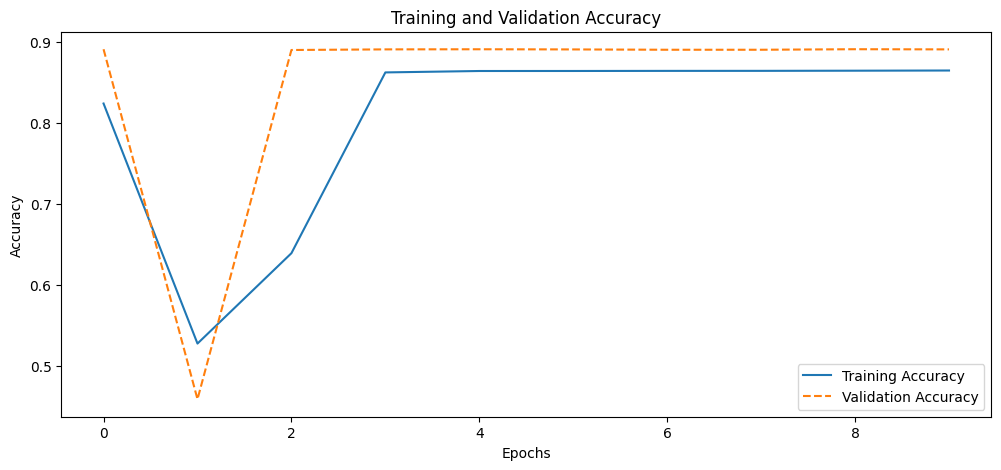

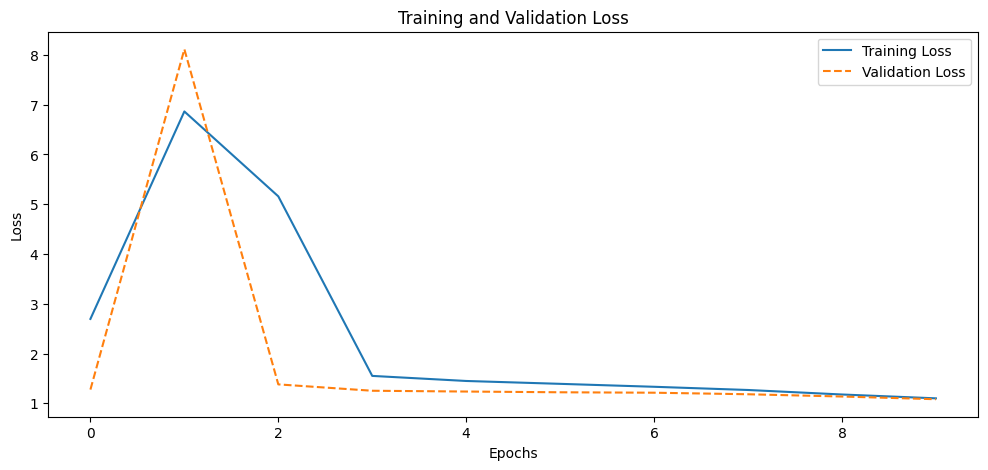

In [16]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:

# Prediction and decoding functions
def decode_sequence(sequence):
    return ' '.join([highlight_tokenizer.index_word.get(i, '') for i in sequence if i != 0])

def generate_summary(article):
    article_sequence = article_tokenizer.texts_to_sequences([article])
    article_padded = pad_sequences(article_sequence, maxlen=max_article_len, padding='post')
    predicted = model.predict(article_padded)
    predicted_sequence = np.argmax(predicted, axis=-1)
    return decode_sequence(predicted_sequence[0])


articles_test = dset['test']['document'][:100]
highlights_test = dset['test']['summary'][:100]

# BLEU Score Evaluation
bleu_scores = []
for i in range(100):
    predicted_summary = generate_summary(articles_test[i])
    # reference_summary = decode_sequence(highlight_padded_val[i])
    reference_summary = highlights_test[i]
    score = sentence_bleu([reference_summary.split()], predicted_summary.split())
    bleu_scores.append(score)

average_bleu_score = np.mean(bleu_scores)
print(f'Average BLEU Score: {average_bleu_score}')




1/1 [==============================] - 0s 33ms/step


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

1/1 [==============================] - 0s 36ms/step
Average BLEU Score: 3.46923681423589e-158


In [42]:

# Prediction and decoding functions
def decode_sequence(sequence):
    return ' '.join([highlight_tokenizer.index_word.get(i, '') for i in sequence if i != 0])

def generate_summary(article):
    article_sequence = article_tokenizer.texts_to_sequences([article])
    article_padded = pad_sequences(article_sequence, maxlen=max_article_len, padding='post')
    predicted = model.predict(article_padded)
    predicted_sequence = np.argmax(predicted, axis=-1)
    return decode_sequence(predicted_sequence[0])


articles_test = dset['test']['document'][:100]
highlights_test = dset['test']['summary'][:100]

# BLEU Score Evaluation
bleu_scores = []
for i in range(2):
    predicted_summary = generate_summary(articles_test[i])
    # reference_summary = decode_sequence(highlight_padded_val[i])
    reference_summary = highlights_test[i]
    score = sentence_bleu([reference_summary.split()], predicted_summary.split())
    bleu_scores.append(score)

average_bleu_score = np.mean(bleu_scores)
print(f'Average BLEU Score: {average_bleu_score}')




1/1 [==============================] - 0s 38ms/step
Average BLEU Score: 1.8163275303147301e-233


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

In [ ]:
print("artikel berita:", articles_val[30])
print("summary:",highlights_val[30])

In [38]:
input_article = articles_val[30]
predicted_summary = generate_summary(input_article)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 36ms/step
Predicted Summary: ratusan warga kasus yudhoyono terjadi di sejumlah membuat dan ini


In [22]:
print("artikel berita:", articles_test[1])
print("summary:",highlights_test[1])

artikel berita: Liputan6 . com , Bandar Lampung : Sebanyak 51 anak di bawah umur lima tahun terserang busung lapar atau marasmus karena kekurangan gizi di Kota Madya Bandar Lampung . Lima di antaranya tewas . Data tersebut diungkapkan Kepala Dinas Kesehatan Kota Bandar Lampung M . Sudarman , baru-baru ini . Menurut Sudarman , Dinas Kesehatan Bandar Lampung mencatat sekitar 51 anak terserang busung lapar yang tersebar di beberapa kecamatan , selama periode 1999 sampai 2001 . Kebanyakan anak penderita busung tersebut berasal dari keluarga yang hidup di bawah garis kemiskinan . Selain kekurangan gizi , komplikasi radang paru-paru juga menjadi satu faktor penyebab kematian anak penderita busung lapar tersebut . Data Dinas Kesehatan menunjukkan pada 1999 , ditemukan 41 anak terserang penyakit busung lapar . Sebagian besar penderita berdomisili di kampung miskin Umbul Kunci . Jumlah penderita busung lapar menurun pada 2000 , yakni hanya sembilan anak . Sedangkan September 2001 , seorang anak

In [41]:
# User input for summarization
user_input = articles_test[0]
predicted_summary = generate_summary(user_input)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 37ms/step
Predicted Summary: ratusan warga pemberantasan yudhoyono terjadi dalam dan


In [43]:
# Define parameters
embedding_dim = 1024
rnn_units = 512

# Define the input layer
inputs = Input(shape=(max_article_len,))

# Embedding layer
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_article_len, trainable=True)(inputs)

# Bidirectional SimpleRNN layer
x = Bidirectional(SimpleRNN(rnn_units, return_sequences=True))(x)
# x = SimpleRNN(rnn_units, return_sequences=True)(x)

# Attention layer with normalization for stability
attention_output = Attention()([x, x])
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)

# Dense output layer
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(attention_output)

# Build the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 1024)    10240000    ['input_3[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 200, 1024)   1573888     ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 attention_2 (Attention)        (None, 200, 1024)    0           ['bidirectional_1[0][0]',  

In [44]:

# Train model
history = model.fit(
    article_padded_train, highlight_padded_train,
    epochs=10,  # Increase epochs for better training
    batch_size=16,
    validation_data=(article_padded_val, highlight_padded_val)
)


Epoch 1/10
32/32 [==============================] - 125s 4s/step - loss: 2.6020 - accuracy: 0.8118 - val_loss: 1.4095 - val_accuracy: 0.8903
Epoch 2/10
32/32 [==============================] - 141s 4s/step - loss: 1.6158 - accuracy: 0.8618 - val_loss: 1.3810 - val_accuracy: 0.8900
Epoch 3/10
32/32 [==============================] - 151s 5s/step - loss: 1.5433 - accuracy: 0.8618 - val_loss: 1.3085 - val_accuracy: 0.8903
Epoch 4/10
32/32 [==============================] - 134s 4s/step - loss: 1.4585 - accuracy: 0.8618 - val_loss: 1.2643 - val_accuracy: 0.8903
Epoch 5/10
32/32 [==============================] - 102s 3s/step - loss: 1.3329 - accuracy: 0.8621 - val_loss: 1.1958 - val_accuracy: 0.8909
Epoch 6/10
32/32 [==============================] - 103s 3s/step - loss: 1.2472 - accuracy: 0.8628 - val_loss: 1.2069 - val_accuracy: 0.8911
Epoch 7/10
32/32 [==============================] - 105s 3s/step - loss: 1.1829 - accuracy: 0.8634 - val_loss: 1.2082 - val_accuracy: 0.8911
Epoch 8/10
32

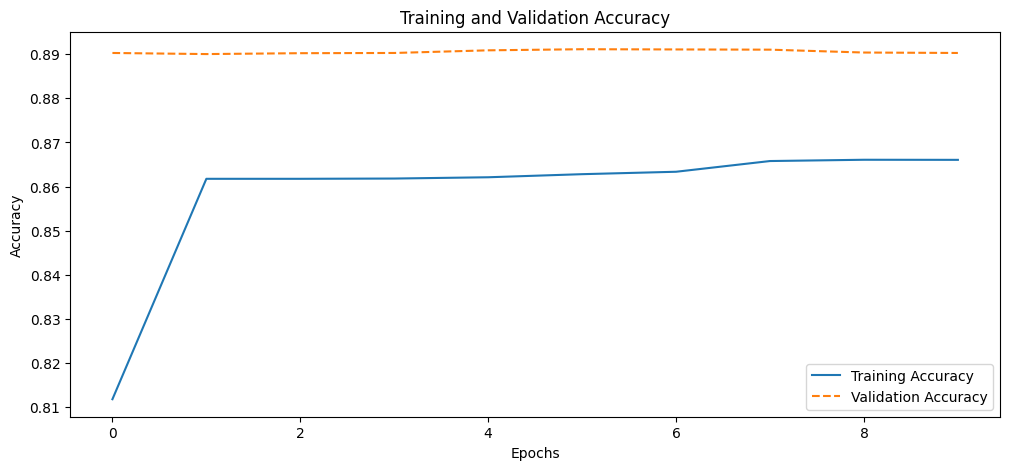

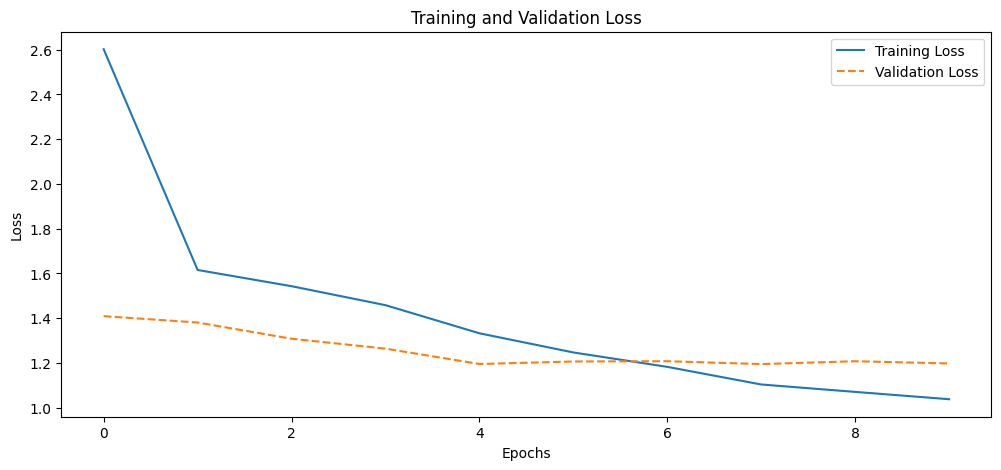

In [45]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:

# Prediction and decoding functions
def decode_sequence(sequence):
    return ' '.join([highlight_tokenizer.index_word.get(i, '') for i in sequence if i != 0])

def generate_summary(article):
    article_sequence = article_tokenizer.texts_to_sequences([article])
    article_padded = pad_sequences(article_sequence, maxlen=max_article_len, padding='post')
    predicted = model.predict(article_padded)
    predicted_sequence = np.argmax(predicted, axis=-1)
    return decode_sequence(predicted_sequence[0])


articles_test = dset['test']['document'][:100]
highlights_test = dset['test']['summary'][:100]

# BLEU Score Evaluation
bleu_scores = []
for i in range(100):
    predicted_summary = generate_summary(articles_test[i])
    # reference_summary = decode_sequence(highlight_padded_val[i])
    reference_summary = highlights_test[i]
    score = sentence_bleu([reference_summary.split()], predicted_summary.split())
    bleu_scores.append(score)

average_bleu_score = np.mean(bleu_scores)
print(f'Average BLEU Score: {average_bleu_score}')



1/1 [==============================] - 0s 45ms/step
Average BLEU Score: 2.415319810608279e-232


In [47]:

# Prediction and decoding functions
def decode_sequence(sequence):
    return ' '.join([highlight_tokenizer.index_word.get(i, '') for i in sequence if i != 0])

def generate_summary(article):
    article_sequence = article_tokenizer.texts_to_sequences([article])
    article_padded = pad_sequences(article_sequence, maxlen=max_article_len, padding='post')
    predicted = model.predict(article_padded)
    predicted_sequence = np.argmax(predicted, axis=-1)
    return decode_sequence(predicted_sequence[0])


articles_test = dset['test']['document'][:100]
highlights_test = dset['test']['summary'][:100]

# BLEU Score Evaluation
bleu_scores = []
for i in range(2):
    predicted_summary = generate_summary(articles_test[i])
    # reference_summary = decode_sequence(highlight_padded_val[i])
    reference_summary = highlights_test[i]
    score = sentence_bleu([reference_summary.split()], predicted_summary.split())
    bleu_scores.append(score)

average_bleu_score = np.mean(bleu_scores)
print(f'Average BLEU Score: {average_bleu_score}')





1/1 [==============================] - 0s 41ms/step
Average BLEU Score: 2.3490281787083988e-232


In [49]:
# User input for summarization
user_input = articles_test[1]
predicted_summary = generate_summary(user_input)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 46ms/step
Predicted Summary: di di di di di di di di di di dan
